In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfd

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

## Prepare the dataset

In [2]:
dataset = tfd.load('mnist', as_supervised=True)
mnist_train, mnist_test = dataset['train'], dataset['test']

In [3]:
def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    ## Binarization
    ONES, ZEROS = tf.ones_like(image), tf.zeros_like(image)
    return tf.where(image >= .5, ONES, ZEROS)

In [4]:
TRAIN_BUFFER_SIZE = 60000
TEST_BUFFER_SIZE = 10000
BATCH_SIZE = 256

In [5]:
train_dataset = mnist_train.map(convert_types).shuffle(TRAIN_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = mnist_test.map(convert_types).shuffle(TEST_BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
print(next(iter(train_dataset.take(1))).shape)

(256, 28, 28, 1)


In [7]:
class CVAE(tfk.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tfk.Sequential([
            tfk.layers.InputLayer(input_shape=(28, 28, 1)),
            tfk.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu'),
            tfk.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu'),
            tfk.layers.Flatten(),
            # μ, logvar
            tfk.layers.Dense(latent_dim+latent_dim)
        ])
        self.generative_net = tfk.Sequential([
            tfk.layers.InputLayer(input_shape=(latent_dim,)),
            tfk.layers.Dense(units=7*7*32, activation='relu'),
            tfk.layers.Reshape(target_shape=(7, 7, 32)),
            tfk.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2,2), 
                                       padding='SAME', activation='relu'),
            tfk.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2,2),
                                       padding='SAME', activation='relu'),
            tfk.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1,1), padding='SAME')
        ])
        
    def sample(self, z=None):
        """
        Draw a sample from p(x|z).
        """
        if z is None:
            z = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(z, apply_sigmoid=True)

    def encode(self, x):
        """
        Encode x into the parameters of its distribution.
        """
        m, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return m, logvar

    def reparameterize(self, m, logvar):
        ϵ = tf.random.normal(shape=m.shape)
        return ϵ * tf.exp(logvar * .5) + m

    def decode(self, z, apply_sigmoid=False):
        """
        Map z to x, it will be called by `sample`.
        """
        logits = self.generative_net(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        return logits

## Define the loss and optimizer

VAEs is optimized by maximizing the evidence lower bound (ELBO):

$$
\log p(x) \geq \mathrm{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x,z)}{q(z|x)} \right]
$$

In practice, we use Monte Carlo method to approximate it:

$$
\log p(x|z) + \log p(z) - \log q(z|x)
$$

Note that the last two terms actually computes the $-\mathrm{KL}[q(z|x) || p(z)]$; when the KL term can be computed analytically we are only required to evaluate the first term with Monte Carlo method, but here we incoporate all three terms in the Monte Carlo estimator for simplicity:

In [8]:
latent_dim = 50

model = CVAE(latent_dim)
optimizer = tfk.optimizers.Adam(1e-4)

In [19]:
def log_normal_pdf(sample, mean, logvar, axis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean)**2.0 * tf.exp(-logvar) + logvar + log2pi),
        axis=axis)

def compute_loss(model, x):
    m, logvar = model.encode(x)
    z = model.reparameterize(m, logvar)
    logits = model.decode(z)
    
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=x)
    logpxz = -tf.reduce_sum(cross_entropy, axis=[1, 2, 3])
    logpz  = log_normal_pdf(z, 0., 0.)
    logqzx = log_normal_pdf(z, m, logvar)
    return -tf.reduce_mean(logpxz + logpz - logqzx)

In [20]:
@tf.function
def train_step(model, x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
def train(model, dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for x in dataset:
            train_step(model, x)
            
        display.clear_output(wait=True)
        generate_and_save_images(model, epoch+1, seed)
            
        print("Time for epoch {} is {} sec".format(epoch+1, time.time()-start))
        
    display.clear_output(wait=True)
    generate_and_save_images(model, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)

    fig = plt.figure(figsize=(4,4))
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
        
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Training

In [21]:
epochs = 100
num_examples = 16

seed = tf.random.normal([num_examples, latent_dim])

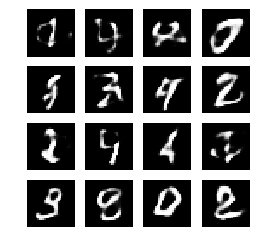

CPU times: user 34min 20s, sys: 8min 18s, total: 42min 39s
Wall time: 12min


In [25]:
%%time
train(model, train_dataset, epochs)